In [1]:
import time
import sklearn
print("Version sklearn : ", sklearn.__version__)

import numpy as np
import pandas as pd
from sklearn.ensemble import (
    BaggingRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tqdm.notebook import tqdm

Version sklearn :  1.5.2


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 40)

In [3]:
# Load data
input_df = pd.read_csv("input_df.csv", index_col=0)
input_df_pca = pd.read_csv("input_df_pca.csv", index_col=0)
output_df_class = pd.read_csv("output_df_class.csv", index_col=0)
output_df_score = pd.read_csv("output_df_score.csv", index_col=0)
q1, q3 = output_df_score["score"].quantile([0.25, 0.75])

In [4]:
# Drop rows with missing values in the output for supervised learning

supervised_learning_mask = output_df_score.notna().all(axis=1)

input_df = input_df[supervised_learning_mask]
input_df_pca = input_df_pca[supervised_learning_mask]
output_df_class = output_df_class[supervised_learning_mask]
output_df_score = output_df_score[supervised_learning_mask]

In [5]:
# Prepare input data
X_base = input_df.values
X_pca = input_df_pca.values
y = output_df_score.values.ravel()

# Set a random seed for reproducibility
random_state = 123

# Define cross-validation strategy
kf = KFold(n_splits=10, random_state=random_state, shuffle=True)

# Define a scoring metric
scoring = [
    "neg_mean_absolute_error",
    "neg_mean_squared_error",
    "neg_root_mean_squared_error",
    "r2",
]

In [6]:
# Define models and hyperparameters for tuning
models = {
    "Linear Regression": {"model": LinearRegression(), "params": {}},
    "Ridge": {
        "model": Ridge(),
        "params": {"ridge__alpha": [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]},
    },
    "Lasso": {
        "model": Lasso(),
        "params": {"lasso__alpha": [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]},
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "elasticnet__alpha": [0.01, 0.01, 0.1, 1.0, 10, 100],
            "elasticnet__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
        },
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "params": {
            "decisiontree__max_depth": [5, 10, 20],
            "decisiontree__min_samples_split": [2, 5, 10],
        },
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "randomforest__n_estimators": [50, 100],
            "randomforest__max_depth": [5, 10],
            "randomforest__min_samples_split": [2, 5],
        },
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "gradientboosting__n_estimators": [50, 100],
            "gradientboosting__learning_rate": [0.01, 0.1],
            "gradientboosting__max_depth": [3, 5, 10],
        },
    },
    "Support Vector Regressor": {
        "model": SVR(),
        "params": {
            "supportvectorregressor__C": [0.1, 1.0, 10.0],
            "supportvectorregressor__kernel": ["linear", "rbf"],
            "supportvectorregressor__epsilon": [0.01, 0.1, 0.5],
        },
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsRegressor(),
        "params": {"k-nearestneighbors__n_neighbors": [3, 5, 10]},
    },
    "Bagging Regressor": {
        "model": BaggingRegressor(random_state=42),
        "params": {
            "baggingregressor__n_estimators": [10, 50],
            "baggingregressor__max_samples": [0.5, 1.0],
        },
    },
}

In [7]:
# Function to clean the best params dictionary
def clean_params(params):
    return ", ".join(f"{key.split('__')[1]}: {value}" for key, value in params.items())


# Function to categorize the regression output
def categorize_values(y, q1, q3):
    y_categorized = np.empty_like(y)
    y_categorized[y < q1] = 1
    y_categorized[(y >= q1) & (y <= q3)] = 2
    y_categorized[y > q3] = 3
    return y_categorized


# Function to convert the one hot encoding back to multiclass ecoding
def one_hot_encoding_to_multiclass(y):
    return np.einsum("ij,j->i", y, np.arange(1, y.shape[1] + 1))


# 1 dimension multiclass label
y_categorized = one_hot_encoding_to_multiclass(output_df_class.values)

In [8]:
def categorize_and_cross_validate(model, X, y, y_categorized, q1, q3, kf):
    """
    Perform cross-validation on a given model, categorize predictions, and compute various evaluation metrics for classification.

    Parameters
    ----------
    model : estimator object
        The machine learning model to be trained and evaluated (e.g., `grid_search.best_estimator_`).
    X : array-like of shape (n_samples, n_features)
        The input data.
    y : array-like of shape (n_samples,)
        The target values (for regression).
    y_categorized : array-like of shape (n_samples,)
        The actual categorized target values (used for classification evaluation).
    q1 : float
        The first quantile value used for categorization.
    q3 : float
        The third quantile value used for categorization.
    kf : KFold
        The cross-validation splitting strategy.

    Returns
    -------
    tuple
        A tuple containing the following metrics across all folds:

        - average_accuracy : float
            The average accuracy score.
        - f1_score_micro : float
            The F1 score (micro average).
        - f1_score_macro : float
            The F1 score (macro average).
        - precision_macro : float
            The precision score (macro average).
        - recall_macro : float
            The recall score (macro average).
    """

    # Initialize lists to store metrics for each fold
    accuracy_list = []
    f1_micro_list = []
    f1_macro_list = []
    precision_macro_list = []
    recall_macro_list = []

    # Perform cross-validation
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        y_test_categorized = y_categorized[test_index]

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the testing data
        y_pred = model.predict(X_test)

        # Categorize the predictions
        y_pred_categorized = categorize_values(y_pred, q1, q3)

        # Compute metrics for this fold
        acc = accuracy_score(y_test_categorized, y_pred_categorized)
        f1_micro = f1_score(y_test_categorized, y_pred_categorized, average="micro")
        f1_macro = f1_score(y_test_categorized, y_pred_categorized, average="macro")
        precision_macro = precision_score(
            y_test_categorized,
            y_pred_categorized,
            average="macro",
            zero_division=np.nan,
        )
        recall_macro = recall_score(
            y_test_categorized, y_pred_categorized, average="macro"
        )

        # Append the metrics to the lists
        accuracy_list.append(acc)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)
        precision_macro_list.append(precision_macro)
        recall_macro_list.append(recall_macro)

    # Calculate the average of each metric across all folds
    return (
        np.mean(accuracy_list),
        np.mean(f1_micro_list),
        np.mean(f1_macro_list),
        np.mean(precision_macro_list),
        np.mean(recall_macro_list),
    )

In [9]:
# Create an empty list to store results
results_list = []

# Create an empty list to store results
results_list_base_input, model_dict_base_input = [], {}
results_list_pca_input, model_dict_pca_input = [], {}

input_setups = {
    "Base input": (X_base, results_list_base_input, model_dict_base_input),
    "PCA input": (X_pca, results_list_pca_input, model_dict_pca_input),
}

# We will also compare the predicted score value with their corresponding category
skf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)
y_ = categorize_values(y, q1, q3)

# Test models on base input and PCA-preprocessed input
for input_name, input_config in input_setups.items():
    X, results_list, model_dict = input_config
    
    fold_1 = skf.split(X,y_)
    fold_1_train_index, fold_1_test_index = next(fold_1)
    X_train, y_train, X_test, y_test = X[fold_1_train_index], y[fold_1_train_index], X[fold_1_test_index], y[fold_1_test_index]
    
    print(f"Starting GridSearch with {input_name} ...")

    # Loop over each model
    for model_name, config in tqdm(models.items()):
        print(f"Training and tuning {model_name}...")

        # Track start time
        start_time = time.time()

        # Create a pipeline with StandardScaler (necessary for some models)
        pipeline = Pipeline(
            [
                (
                    "scaler",
                    StandardScaler(),
                ),
                (model_name.lower().replace(" ", ""), config["model"]),
            ]
        )

        # Set up GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=config["params"],
            cv=kf,
            scoring=scoring,
            refit="neg_mean_squared_error",
            return_train_score=False,
            verbose=1,
        )

        # Fit the grid search
        grid_search.fit(X, y)

        # Get the best estimator's metrics
        best_estimator_index = grid_search.best_index_

        mae = -grid_search.cv_results_["mean_test_neg_mean_absolute_error"][
            best_estimator_index
        ]
        mse = -grid_search.cv_results_["mean_test_neg_mean_squared_error"][
            best_estimator_index
        ]
        rmse = -grid_search.cv_results_["mean_test_neg_root_mean_squared_error"][
            best_estimator_index
        ]
        r2 = grid_search.cv_results_["mean_test_r2"][best_estimator_index]

        # Also determine classification metrics by categorizing the output
        acc, f1_score_micro, f1_score_macro, precision_macro, recall_macro = (
            categorize_and_cross_validate(
                grid_search.best_estimator_, X, y, y_categorized, q1, q3, kf
            )
        )

        # Append results to list
        results_list.append(
            {
                "Model": model_name,
                "Best Params": clean_params(grid_search.best_params_),
                "MAE": mae,
                "MSE": mse,
                "RMSE": rmse,
                "R2": r2,
                "Accuracy": acc,
                "F1 Score (micro)": f1_score_micro,
                "F1 Score (macro)": f1_score_macro,
                "Precision (macro)": precision_macro,
                "Recall (macro)": recall_macro,
            }
        )
        
        # Get best estimator
        best_est = grid_search.best_estimator_
        
        best_est.fit(X_train, y_train) # refit only on 1st fold train set
        y_pred = best_est.predict(X_test)
        
        y_test_ = categorize_values(y_test, q1, q3)
        y_pred_ = categorize_values(y_pred  , q1, q3)
        
        # Append results to list
        model_dict[model_name] = {  "gc": grid_search,
                                    "estimator": grid_search.best_estimator_,
                                    "conf_mat_on_fold": confusion_matrix(y_test_, y_pred_, normalize='true')
            }

        # Print duration
        print(f"Done in {time.time() - start_time:.2f} seconds\n")


Starting GridSearch with Base input ...


  0%|          | 0/10 [00:00<?, ?it/s]

Training and tuning Linear Regression...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Done in 2.32 seconds

Training and tuning Ridge...
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Done in 0.88 seconds

Training and tuning Lasso...
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Done in 1.64 seconds

Training and tuning ElasticNet...
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Done in 8.56 seconds

Training and tuning Decision Tree...
Fitting 10 folds for each of 9 candidates, totalling 90 fits


c:\Users\Elian\AppData\Local\pypoetry\Cache\virtualenvs\apprauto-hv_gZX10-py3.12\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Done in 3.62 seconds

Training and tuning Random Forest...
Fitting 10 folds for each of 8 candidates, totalling 80 fits


c:\Users\Elian\AppData\Local\pypoetry\Cache\virtualenvs\apprauto-hv_gZX10-py3.12\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Done in 92.69 seconds

Training and tuning Gradient Boosting...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Done in 96.89 seconds

Training and tuning Support Vector Regressor...
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Done in 23.49 seconds

Training and tuning K-Nearest Neighbors...
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Done in 1.39 seconds

Training and tuning Bagging Regressor...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Done in 26.06 seconds

Starting GridSearch with PCA input ...


  0%|          | 0/10 [00:00<?, ?it/s]

Training and tuning Linear Regression...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Done in 0.20 seconds

Training and tuning Ridge...
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Done in 0.56 seconds

Training and tuning Lasso...
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Done in 0.58 seconds

Training and tuning ElasticNet...
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Done in 2.41 seconds

Training and tuning Decision Tree...
Fitting 10 folds for each of 9 candidates, totalling 90 fits


c:\Users\Elian\AppData\Local\pypoetry\Cache\virtualenvs\apprauto-hv_gZX10-py3.12\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Done in 1.59 seconds

Training and tuning Random Forest...
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Done in 50.28 seconds

Training and tuning Gradient Boosting...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Done in 258.64 seconds

Training and tuning Support Vector Regressor...
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Done in 6.17 seconds

Training and tuning K-Nearest Neighbors...
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Done in 0.22 seconds

Training and tuning Bagging Regressor...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Done in 10.34 seconds



In [10]:
pd.DataFrame(results_list_base_input).sort_values("MSE", ignore_index=True)

,Model,Best Params,MAE,MSE,RMSE,R2,Accuracy,F1 Score (micro),F1 Score (macro),Precision (macro),Recall (macro)
0,Gradient Boosting,"learning_rate: 0.1, max_depth: 5, n_estimators...",1.013322,2.249844,1.457965,0.675746,0.761971,0.761971,0.742405,0.815532,0.719621
1,Support Vector Regressor,"C: 10.0, epsilon: 0.1, kernel: rbf",1.030980,2.319744,1.503622,0.652852,0.738798,0.738798,0.721387,0.764924,0.708198
2,Bagging Regressor,"max_samples: 1.0, n_estimators: 50",1.112535,2.686454,1.604535,0.610611,0.746514,0.746514,0.719241,0.809042,0.698461
3,Random Forest,"max_depth: 10, min_samples_split: 2, n_estimat...",1.167667,2.809672,1.645753,0.590131,0.710986,0.710986,0.671263,0.771469,0.647852
4,K-Nearest Neighbors,n_neighbors: 3,1.251008,3.043421,1.729927,0.539728,0.684784,0.684784,0.663798,0.693812,0.659929
5,Decision Tree,"max_depth: 5, min_samples_split: 5",1.505702,4.443426,2.072054,0.341171,0.623005,0.623005,0.552103,0.640332,0.557908
6,ElasticNet,"alpha: 0.1, l1_ratio: 0.1",1.608722,4.657310,2.129163,0.316307,0.591947,0.591947,0.516880,0.634907,0.510590
7,Ridge,alpha: 100,1.606117,4.674266,2.132270,0.314683,0.591971,0.591971,0.511988,0.641333,0.505855
8,Lasso,alpha: 0.01,1.619210,4.683229,2.136425,0.310668,0.593534,0.593534,0.534960,0.615117,0.526652
9,Linear Regression,,1.627138,4.756850,2.152960,0.299645,0.590457,0.590457,0.534944,0.611438,0.525033


In [11]:
pd.DataFrame(results_list_pca_input).sort_values("MSE", ignore_index=True)

,Model,Best Params,MAE,MSE,RMSE,R2,Accuracy,F1 Score (micro),F1 Score (macro),Precision (macro),Recall (macro)
0,Random Forest,"max_depth: 10, min_samples_split: 2, n_estimat...",1.540833,4.590222,2.122384,0.310946,0.610433,0.610433,0.504005,0.691724,0.510353
1,Bagging Regressor,"max_samples: 1.0, n_estimators: 50",1.539535,4.596223,2.124216,0.309225,0.618173,0.618173,0.524576,0.682647,0.522846
2,Gradient Boosting,"learning_rate: 0.1, max_depth: 5, n_estimators...",1.584809,4.735038,2.157903,0.283683,0.605721,0.605721,0.505249,0.670596,0.507053
3,Support Vector Regressor,"C: 10.0, epsilon: 0.5, kernel: rbf",1.548284,4.973746,2.192268,0.267005,0.599471,0.599471,0.487896,0.652166,0.493273
4,K-Nearest Neighbors,n_neighbors: 10,1.679787,5.309222,2.280691,0.205402,0.593389,0.593389,0.472957,0.653376,0.484655
5,ElasticNet,"alpha: 0.1, l1_ratio: 0.9",1.848879,6.016657,2.431772,0.101145,0.528462,0.528462,0.298497,0.644464,0.374181
6,Lasso,alpha: 0.1,1.849302,6.018030,2.432128,0.100936,0.528462,0.528462,0.298497,0.644464,0.374181
7,Ridge,alpha: 100,1.839482,6.024106,2.432336,0.100405,0.531538,0.531538,0.305576,0.591262,0.378982
8,Linear Regression,,1.846104,6.077379,2.442072,0.091967,0.536178,0.536178,0.327671,0.565105,0.392815
9,Decision Tree,"max_depth: 5, min_samples_split: 10",1.836699,6.282398,2.492711,0.039444,0.564111,0.564111,0.470254,0.567372,0.481151


In [12]:
pd.DataFrame(
    model_dict_base_input["Gradient Boosting"]["estimator"][1].feature_importances_,
    index=input_df.columns,
    columns=["Feature Importance"],
).sort_values("Feature Importance", ascending=False)

,Feature Importance
manganese_pct,1.950697e-01
post_weld_temp_c,1.367971e-01
nickel_pct,1.067926e-01
silicon_pct,5.642930e-02
current_a,5.494152e-02
carbon_pct,4.834853e-02
niobium_ppm,4.314780e-02
molybdenum_pct,4.137261e-02
phosphorus_pct,4.000371e-02
nitrogen_ppm,3.920245e-02


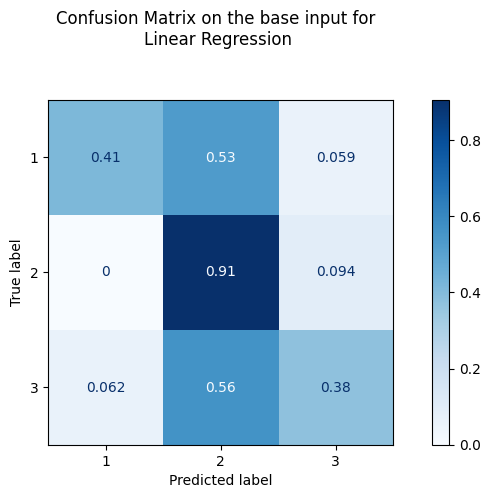

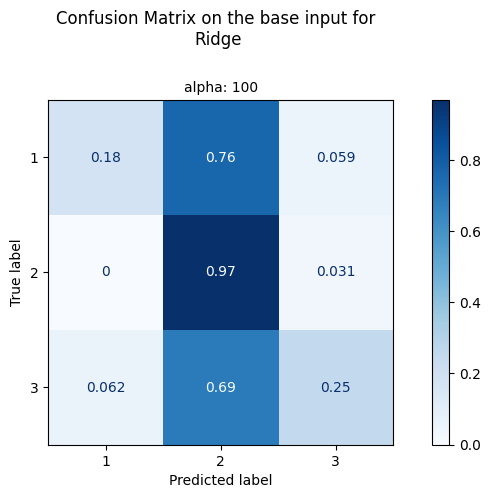

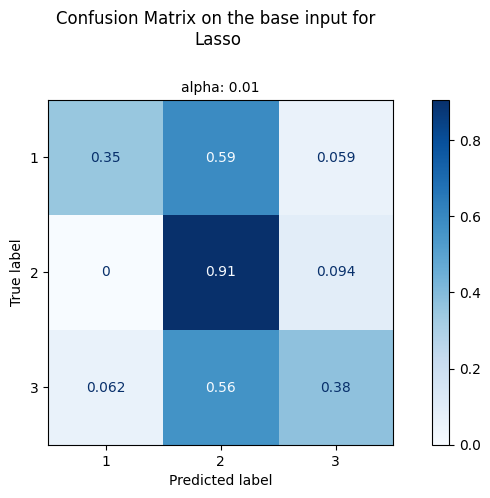

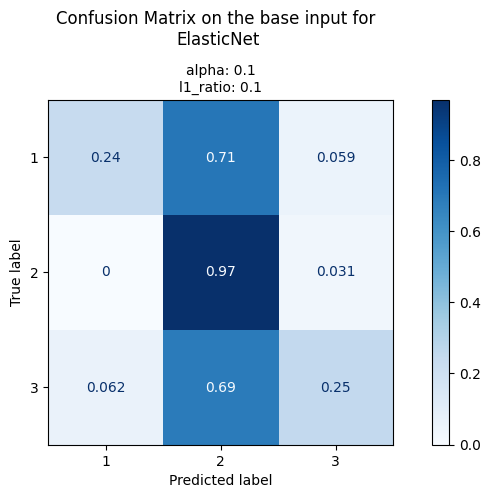

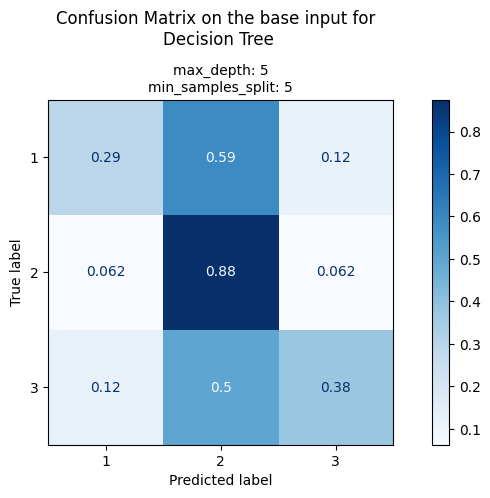

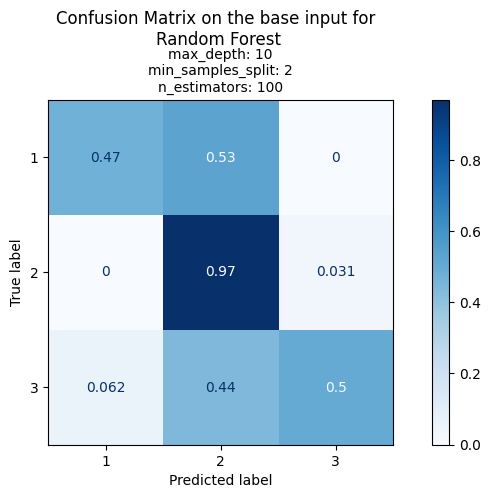

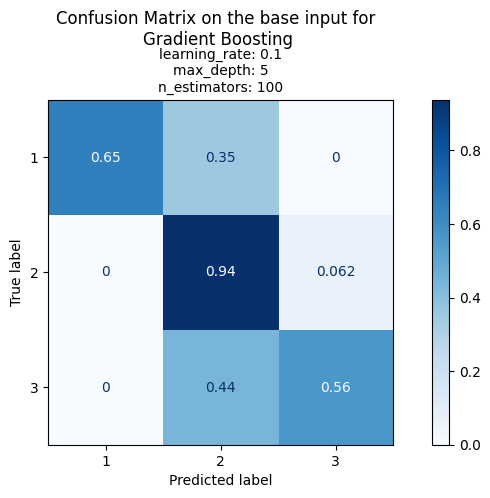

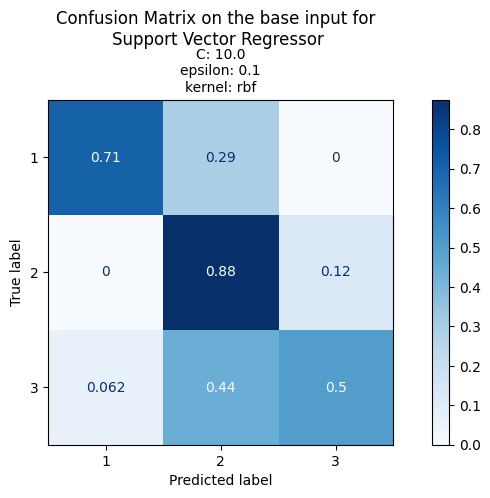

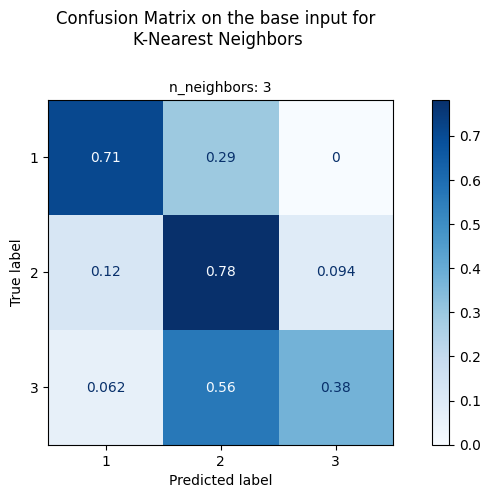

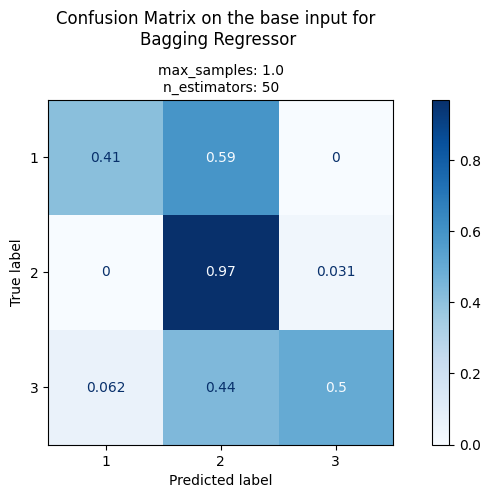

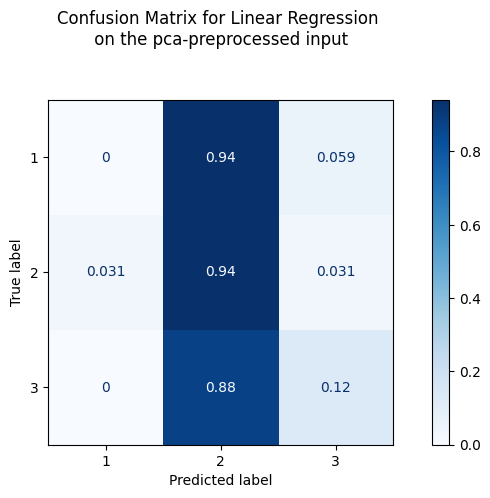

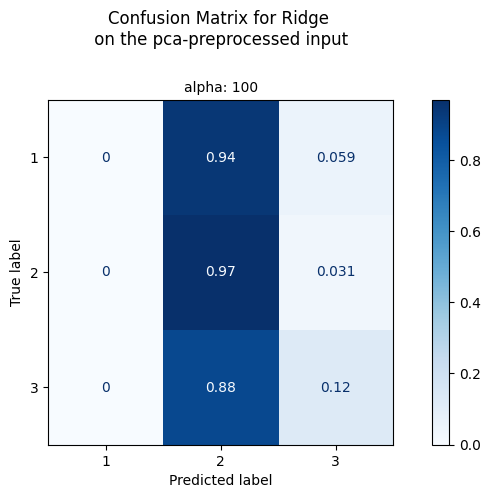

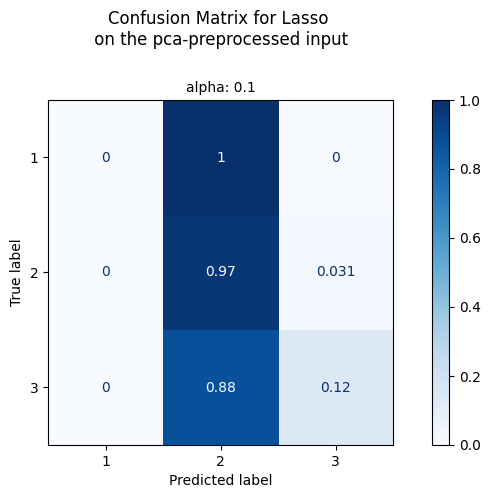

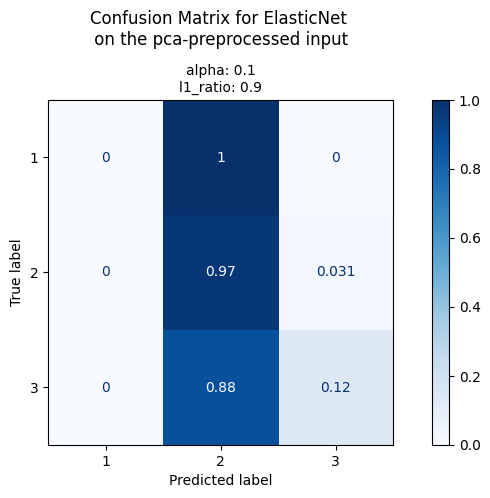

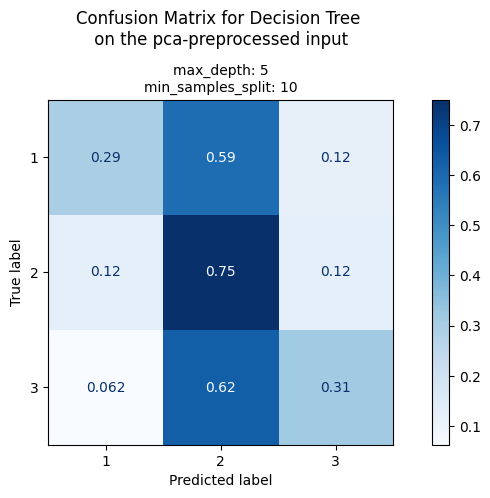

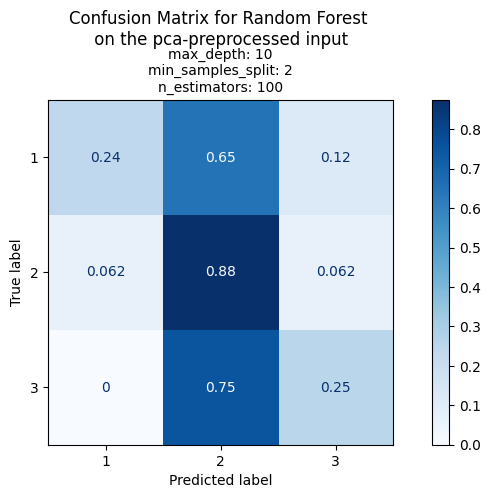

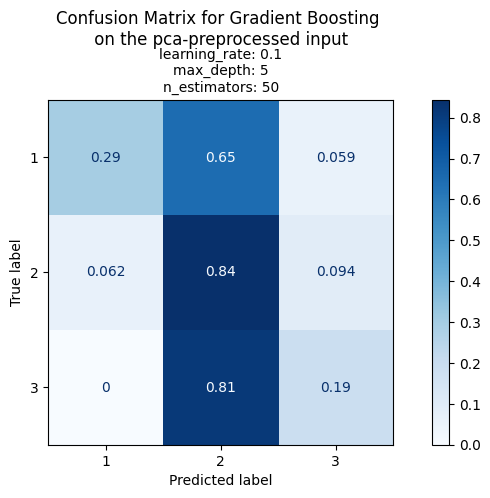

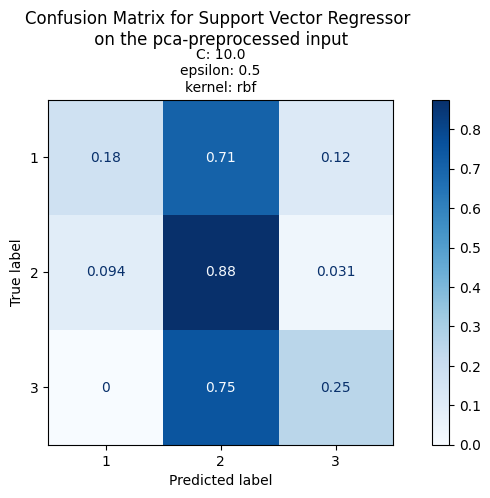

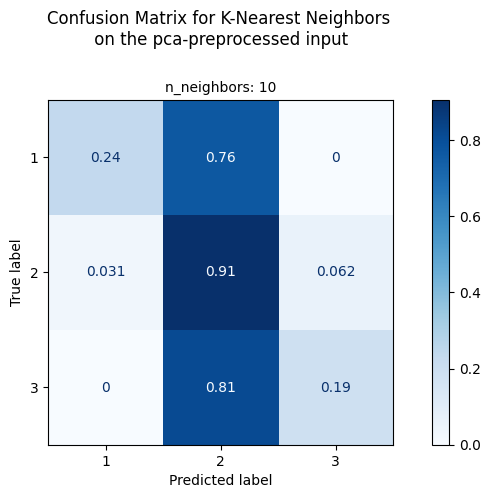

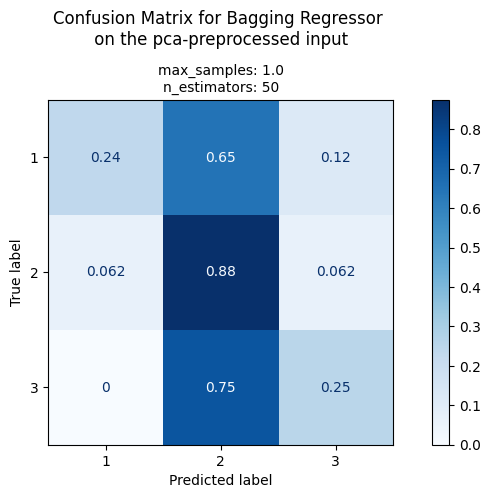

In [13]:
# Visualize confusion matrices :

import matplotlib.pyplot as plt

for model_name, model_prop in model_dict_base_input.items():
    conf_mat = model_prop["conf_mat_on_fold"]
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.subplots_adjust(top=0.8)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[1,2,3])
    ax.set_title("\n".join(clean_params(model_prop["gc"].best_params_).split(", ")), fontsize=10)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    fig.suptitle(f"Confusion Matrix on the base input for \n{model_name}", x=0.57)
    plt.show()
    
for model_name, model_prop in model_dict_pca_input.items():
    conf_mat = model_prop["conf_mat_on_fold"]
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.subplots_adjust(top=0.8)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[1,2,3])
    ax.set_title("\n".join(clean_params(model_prop["gc"].best_params_).split(", ")), fontsize=10)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    fig.suptitle(f"Confusion Matrix for {model_name}\n on the pca-preprocessed input", x=0.57)
    plt.show()